## 0. Подключение библиотек

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import parallel_backend
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. Описание задачи

Бинарная классификация "Станет ли хитом песня?". Датасет содержит более 41112 объектов, 18 признаков и целевую метку. На основе информации о песне необходимо определить будет ли песня популярной.

Трек будет являться «провальным», если выполнены следующие условия:

- Трек не должен находиться в "хит-листе" этого десятилетия.
- Исполнитель трека не должен фигурировать в "хит-листе" этого десятилетия.
- Трек должен принадлежать к жанру, который можно было бы считать не мейнстримным и/или авангардным.
- Жанр трека не должен иметь композицию в списке "хит".
- Трек должен иметь США в качестве одного из рынков.

Описание признаков с пояснениями:

- Описание признаков, которые присутствуют в данных с простыми пояснениями.

- track: Название трека.

- artist: Имя артиста.

- uri: Идентификатор ресурса для трека.

- danceability: Описание того, насколько подходит трек для танцев на основе комбинации музыкальных элементов, включая темп, стабильность ритма, силу удара и общую регулярность. 0.0 - наименее танцевально,  1.0 - наиболее танцевально.

- energy: Меру интенсивности и активности от 0.0 до 1.0. Обычно энергичные треки кажутся быстрыми, громкими и шумными. Например, дэт-метал обладает высокой энергией, а прелюдия Баха имеет низкие оценки по шкале. Характеристики восприятия, влияющие на этот атрибут, включают динамический диапазон, воспринимаемую громкость, тембр, скорость начала и общую энтропию.

- key: Предполагаемая общая тональность трека. Целые числа отображаются на высоту звука с использованием стандартной записи класса высоты звука. Если ключ не обнаружен, значение равно -1.

- loudness: Общая громкость трека в децибелах (дБ). Значения громкости усредняются по всей дорожке и полезны для сравнения относительной громкости дорожек. Типичный диапазон значений от -60 до 0 дБ.

- mode: указывает модальность (мажор или минор) трека, тип звукоряда, из которого получено его мелодическое содержание. Мажор представлен 1, а минор - 0.

- speechiness: определяет наличие произнесенных слов в дорожке. Чем более похожа на речь запись (например, ток-шоу, аудиокнига, стихи), тем ближе значение атрибута к 1,0.

- acousticness: Мера достоверности от 0,0 до 1,0 того, является ли трек акустическим. 1.0 означает высокую степень уверенности в том, что трек акустический.

- instrumentalness: Определяет, будет ли дорожка содержать вокал. В этом контексте звуки «ох» и «ааа» считаются инструментальными. Рэп или звуковые дорожки явно «вокальные». Чем ближе значение инструментальности к 1.0, тем больше вероятность, что трек не содержит вокального содержания. Значения выше 0,5 предназначены для представления инструментальных треков, но достоверность выше, чем ближе значение к 1,0.

- liveness: Обнаруживает присутствие аудитории в записи. Более высокие значения живучести представляют собой повышенную вероятность того, что трек был исполнен вживую. Значение выше 0,8 обеспечивает высокую вероятность того, что трек будет живым.

- valence: Мера от 0,0 до 1,0, описывающая музыкальную позитивность, передаваемую треком. Треки с высокой валентностью звучат более позитивно (например, счастливые, веселые, эйфорические), а треки с низкой валентностью - более негативные (например, грустные, подавленные, сердитые).

- tempo: Общий оценочный темп трека в ударах в минуту (BPM). В музыкальной терминологии темп - это скорость или темп данной пьесы, полученный непосредственно из средней продолжительности удара.

- duration_ms: Продолжительность трека в миллисекундах.

- time_signature: Примерный общий размер трека.

- chorus_hit: Это лучшая оценка автора того, когда начнется припев для трека. Это отметка времени начала третьей части трека. Эта функция была извлечена из данных, полученных вызовом API для анализа звука этой конкретной дорожки.

- sections: Количество секций на конкретной дорожке. Эта функция была извлечена из данных, полученных вызовом API для анализа звука этой конкретной дорожки. В музыке секция — это законченная, но не независимая, музыкальная идея. Секции включают в себя: вступление или интро, экспозицию, разработку, репризу, припев, хор или рефрен, заключение, коду или концовка, фейдер, бридж или интерлюдию.

- target: Целевая переменная для трека. Это может быть "0" или "1". «1» означает, что эта песня фигурировала в еженедельном списке (выпущенном Billboards) треков Hot-100 за это десятилетие хотя бы один раз и, следовательно, является «хитом». «0» означает, что трек - «провал».

## 2. Загрузка данных
Загрузим данные и посмотрим на них. Так как они представлены в виде сразу 6 .csv файлов, необходимо смёрджить их в 1 датафрейм. 

In [3]:
orig_1 = pd.read_csv("data\dataset-of-00s.csv")
orig_2 = pd.read_csv("data\dataset-of-10s.csv")
orig_3 = pd.read_csv("data\dataset-of-60s.csv")
orig_4 = pd.read_csv("data\dataset-of-70s.csv")
orig_5 = pd.read_csv("data\dataset-of-80s.csv")
orig_6 = pd.read_csv("data\dataset-of-90s.csv")

orig_df = pd.concat([orig_1, orig_2, orig_3, orig_4, orig_5, orig_6], axis=0, ignore_index=True).sort_index()
orig_df.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
0,Lucky Man,Montgomery Gentry,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,0.578,0.471,4,-7.270,1,0.0289,0.368000,0.00000,0.159,0.532,133.061,196707,4,30.88059,13,1
1,On The Hotline,Pretty Ricky,spotify:track:1zyqZONW985Cs4osz9wlsu,0.704,0.854,10,-5.477,0,0.1830,0.018500,0.00000,0.148,0.688,92.988,242587,4,41.51106,10,1
2,Clouds Of Dementia,Candlemass,spotify:track:6cHZf7RbxXCKwEkgAZT4mY,0.162,0.836,9,-3.009,1,0.0473,0.000111,0.00457,0.174,0.300,86.964,338893,4,65.32887,13,0
3,"Heavy Metal, Raise Hell!",Zwartketterij,spotify:track:2IjBPp2vMeX7LggzRN3iSX,0.188,0.994,4,-3.745,1,0.1660,0.000007,0.07840,0.192,0.333,148.440,255667,4,58.59528,9,0
4,I Got A Feelin',Billy Currington,spotify:track:1tF370eYXUcWwkIvaq3IGz,0.630,0.764,2,-4.353,1,0.0275,0.363000,0.00000,0.125,0.631,112.098,193760,4,22.62384,10,1


In [4]:
orig_df.shape

(41106, 19)

In [5]:
orig_df.columns

Index(['track', 'artist', 'uri', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'chorus_hit',
       'sections', 'target'],
      dtype='object')

In [6]:
orig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41106 entries, 0 to 41105
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track             41106 non-null  object 
 1   artist            41106 non-null  object 
 2   uri               41106 non-null  object 
 3   danceability      41106 non-null  float64
 4   energy            41106 non-null  float64
 5   key               41106 non-null  int64  
 6   loudness          41106 non-null  float64
 7   mode              41106 non-null  int64  
 8   speechiness       41106 non-null  float64
 9   acousticness      41106 non-null  float64
 10  instrumentalness  41106 non-null  float64
 11  liveness          41106 non-null  float64
 12  valence           41106 non-null  float64
 13  tempo             41106 non-null  float64
 14  duration_ms       41106 non-null  int64  
 15  time_signature    41106 non-null  int64  
 16  chorus_hit        41106 non-null  float6

In [7]:
df = orig_df.drop(columns=["track", "uri"])
df.shape

(41106, 17)

Результаты: в данных присутствует 18 признаков и 1 целевой признак, признаки track и uri удаляются, т.к. они уникальны для каждого из объектов и не будут использоваться при классификации.

## 2. Визуализация данных

Сначала визуализируем описание данных с точки зрения статистики функцией describe()

In [8]:
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
count,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,4.110600e+04,41106.000000,41106.000000,41106.000000,41106.000000
mean,0.539695,0.579545,5.213594,-10.221525,0.693354,0.072960,0.364197,0.154416,0.201535,0.542440,119.338249,2.348776e+05,3.893689,40.106041,10.475673,0.500000
std,0.177821,0.252628,3.534977,5.311626,0.461107,0.086112,0.338913,0.303530,0.172959,0.267329,29.098845,1.189674e+05,0.423073,19.005515,4.871850,0.500006
min,0.000000,0.000251,0.000000,-49.253000,0.000000,0.000000,0.000000,0.000000,0.013000,0.000000,0.000000,1.516800e+04,0.000000,0.000000,0.000000,0.000000
25%,0.420000,0.396000,2.000000,-12.816000,0.000000,0.033700,0.039400,0.000000,0.094000,0.330000,97.397000,1.729278e+05,4.000000,27.599793,8.000000,0.000000
50%,0.552000,0.601000,5.000000,-9.257000,1.000000,0.043400,0.258000,0.000120,0.132000,0.558000,117.565000,2.179070e+05,4.000000,35.850795,10.000000,0.500000
75%,0.669000,0.787000,8.000000,-6.374250,1.000000,0.069800,0.676000,0.061250,0.261000,0.768000,136.494000,2.667730e+05,4.000000,47.625615,12.000000,1.000000
max,0.988000,1.000000,11.000000,3.744000,1.000000,0.960000,0.996000,1.000000,0.999000,0.996000,241.423000,4.170227e+06,5.000000,433.182000,169.000000,1.000000


Чтобы лучше понять, что следует визуализировать выведем число уникальных значений для каждой из колонок

In [9]:
for key in list(df.columns):
    print(f"Num uniques in {key} column is {len(df[key].unique())}")

Num uniques in artist column is 11904
Num uniques in danceability column is 1048
Num uniques in energy column is 1787
Num uniques in key column is 12
Num uniques in loudness column is 16160
Num uniques in mode column is 2
Num uniques in speechiness column is 1346
Num uniques in acousticness column is 4194
Num uniques in instrumentalness column is 5122
Num uniques in liveness column is 1674
Num uniques in valence column is 1609
Num uniques in tempo column is 32152
Num uniques in duration_ms column is 21517
Num uniques in time_signature column is 5
Num uniques in chorus_hit column is 39950
Num uniques in sections column is 84
Num uniques in target column is 2


Построим некоторые графики 

<AxesSubplot:xlabel='key', ylabel='count'>

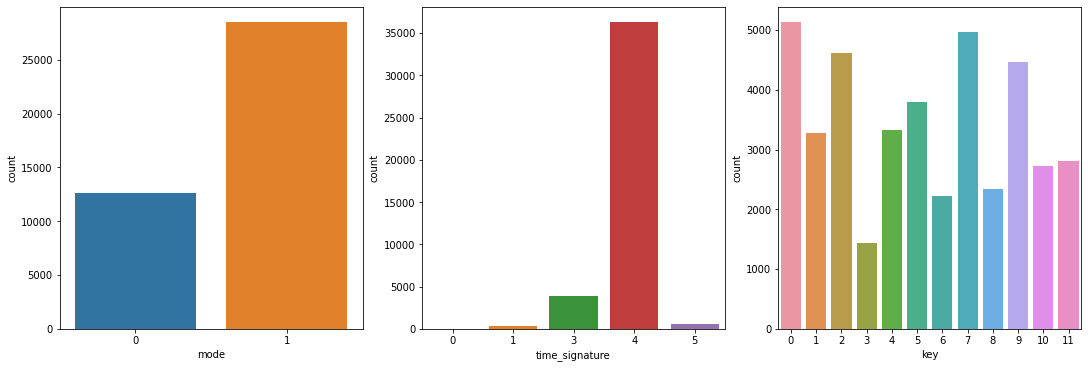

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

sns.countplot(x ='mode', data = df, ax=ax[0])
sns.countplot(x ='time_signature', data = df, ax=ax[1])
sns.countplot(x ='key', data = df, ax=ax[2])

In [11]:
print(np.sum(df['time_signature'] == 0))
print(np.sum(df['time_signature'] == 1))
print(np.sum(df['time_signature'] == 3))
print(np.sum(df['time_signature'] == 4))
print(np.sum(df['time_signature'] == 5))

3
371
3840
36297
595


Из графика видно, time_signature имеет очень мало значений, равных нулю, чаще всего принимает значение, равное 4 (36297 раз). Этот признак отвечает за размер (длительность) трека. Значение 0 является выбросом.

Часть признаков удобнее будет визуализировать с помощью гистограммы.

<AxesSubplot:xlabel='loudness', ylabel='Count'>

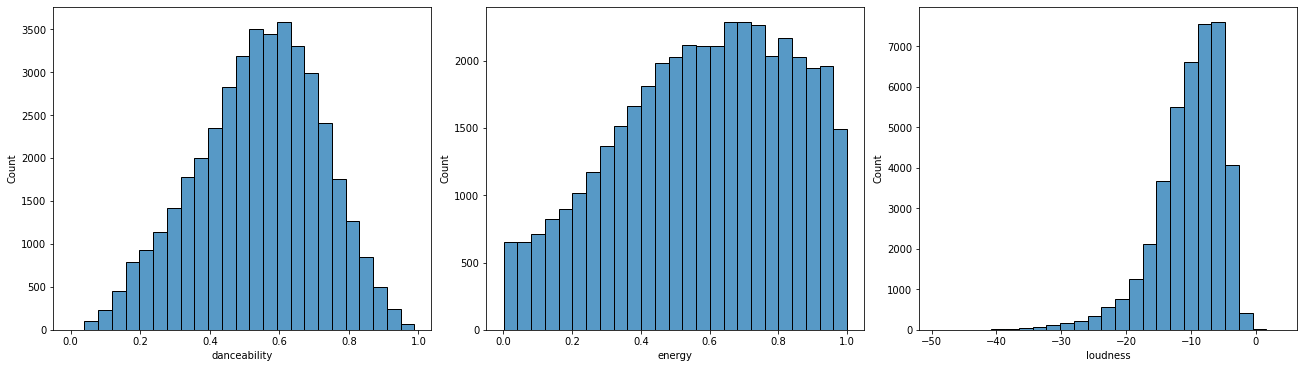

In [12]:
fig, ax = plt.subplots(1,3, figsize=(18,5), constrained_layout=True)

sns.histplot(df['danceability'], bins=25, ax=ax[0])
sns.histplot(df['energy'], bins=25, ax=ax[1])
sns.histplot(df['loudness'], bins=25, ax=ax[2])

<AxesSubplot:xlabel='instrumentalness', ylabel='Count'>

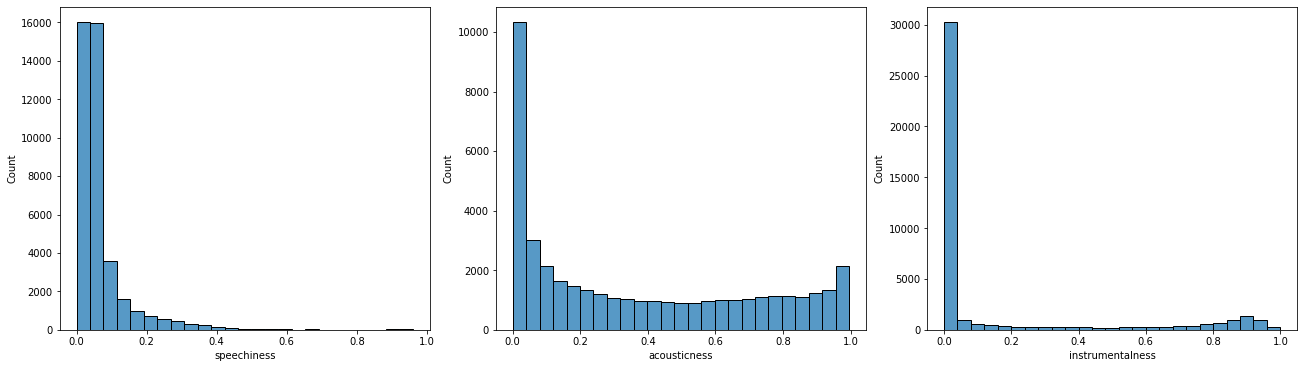

In [13]:
fig, ax = plt.subplots(1,3, figsize=(18,5), constrained_layout=True)

sns.histplot(df['speechiness'], bins=25, ax=ax[0])
sns.histplot(df['acousticness'], bins=25, ax=ax[1])
sns.histplot(df['instrumentalness'], bins=25, ax=ax[2])

<AxesSubplot:xlabel='tempo', ylabel='Count'>

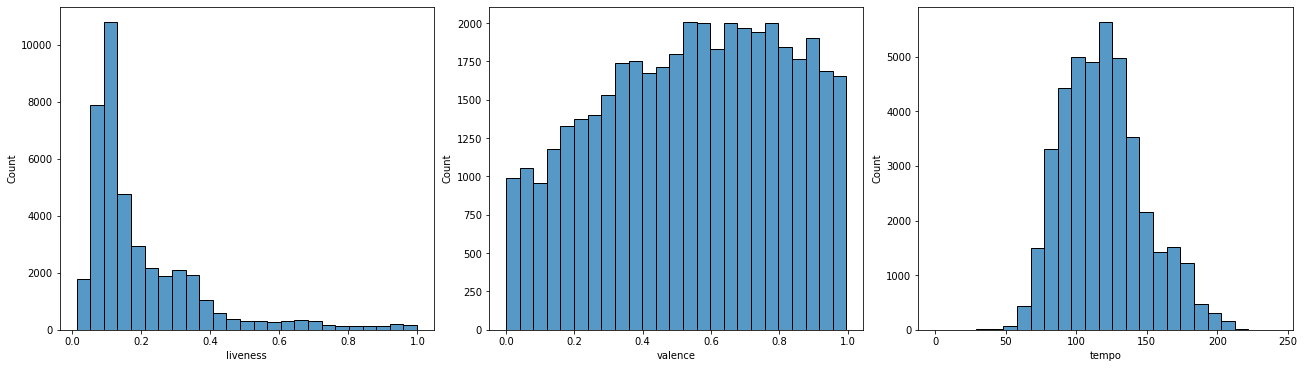

In [14]:
fig, ax = plt.subplots(1,3, figsize=(18,5), constrained_layout=True)

sns.histplot(df['liveness'], bins=25, ax=ax[0])
sns.histplot(df['valence'], bins=25, ax=ax[1])
sns.histplot(df['tempo'], bins=25, ax=ax[2])

<AxesSubplot:xlabel='sections', ylabel='Count'>

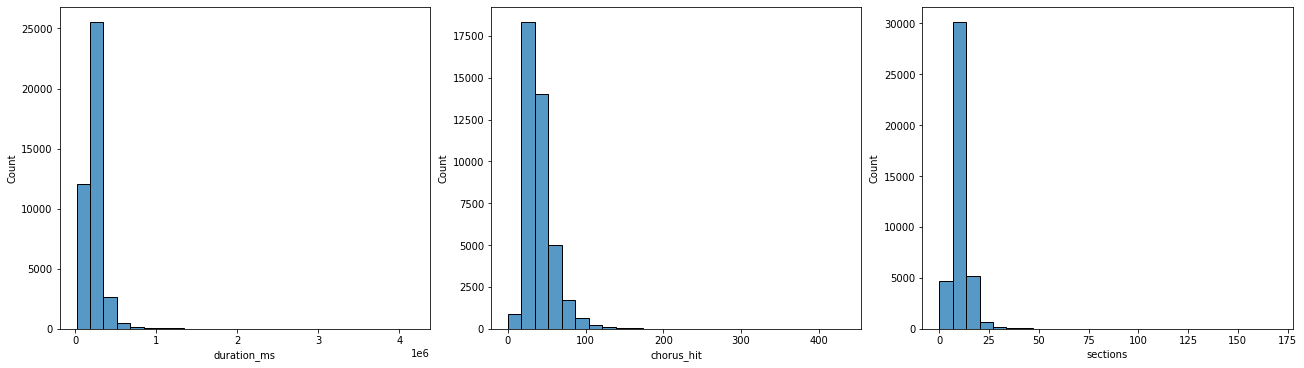

In [15]:
fig, ax = plt.subplots(1,3, figsize=(18,5), constrained_layout=True)

sns.histplot(df['duration_ms'], bins=25, ax=ax[0])
sns.histplot(df['chorus_hit'], bins=25, ax=ax[1])
sns.histplot(df['sections'], bins=25, ax=ax[2])

Можно сделать вывод, что в большинстве случаев  большие по модулю значения признаки принимают очень редко (есть некоторые исключения). Для того, чтобы визуализировать множество признаков сразу можно воспользоваться pairplot. Т.к. попытка визуализации сразу на всех данных выглядела крайне неинформативно, то была создана подвыборка размером 1000 специально для визуализации.

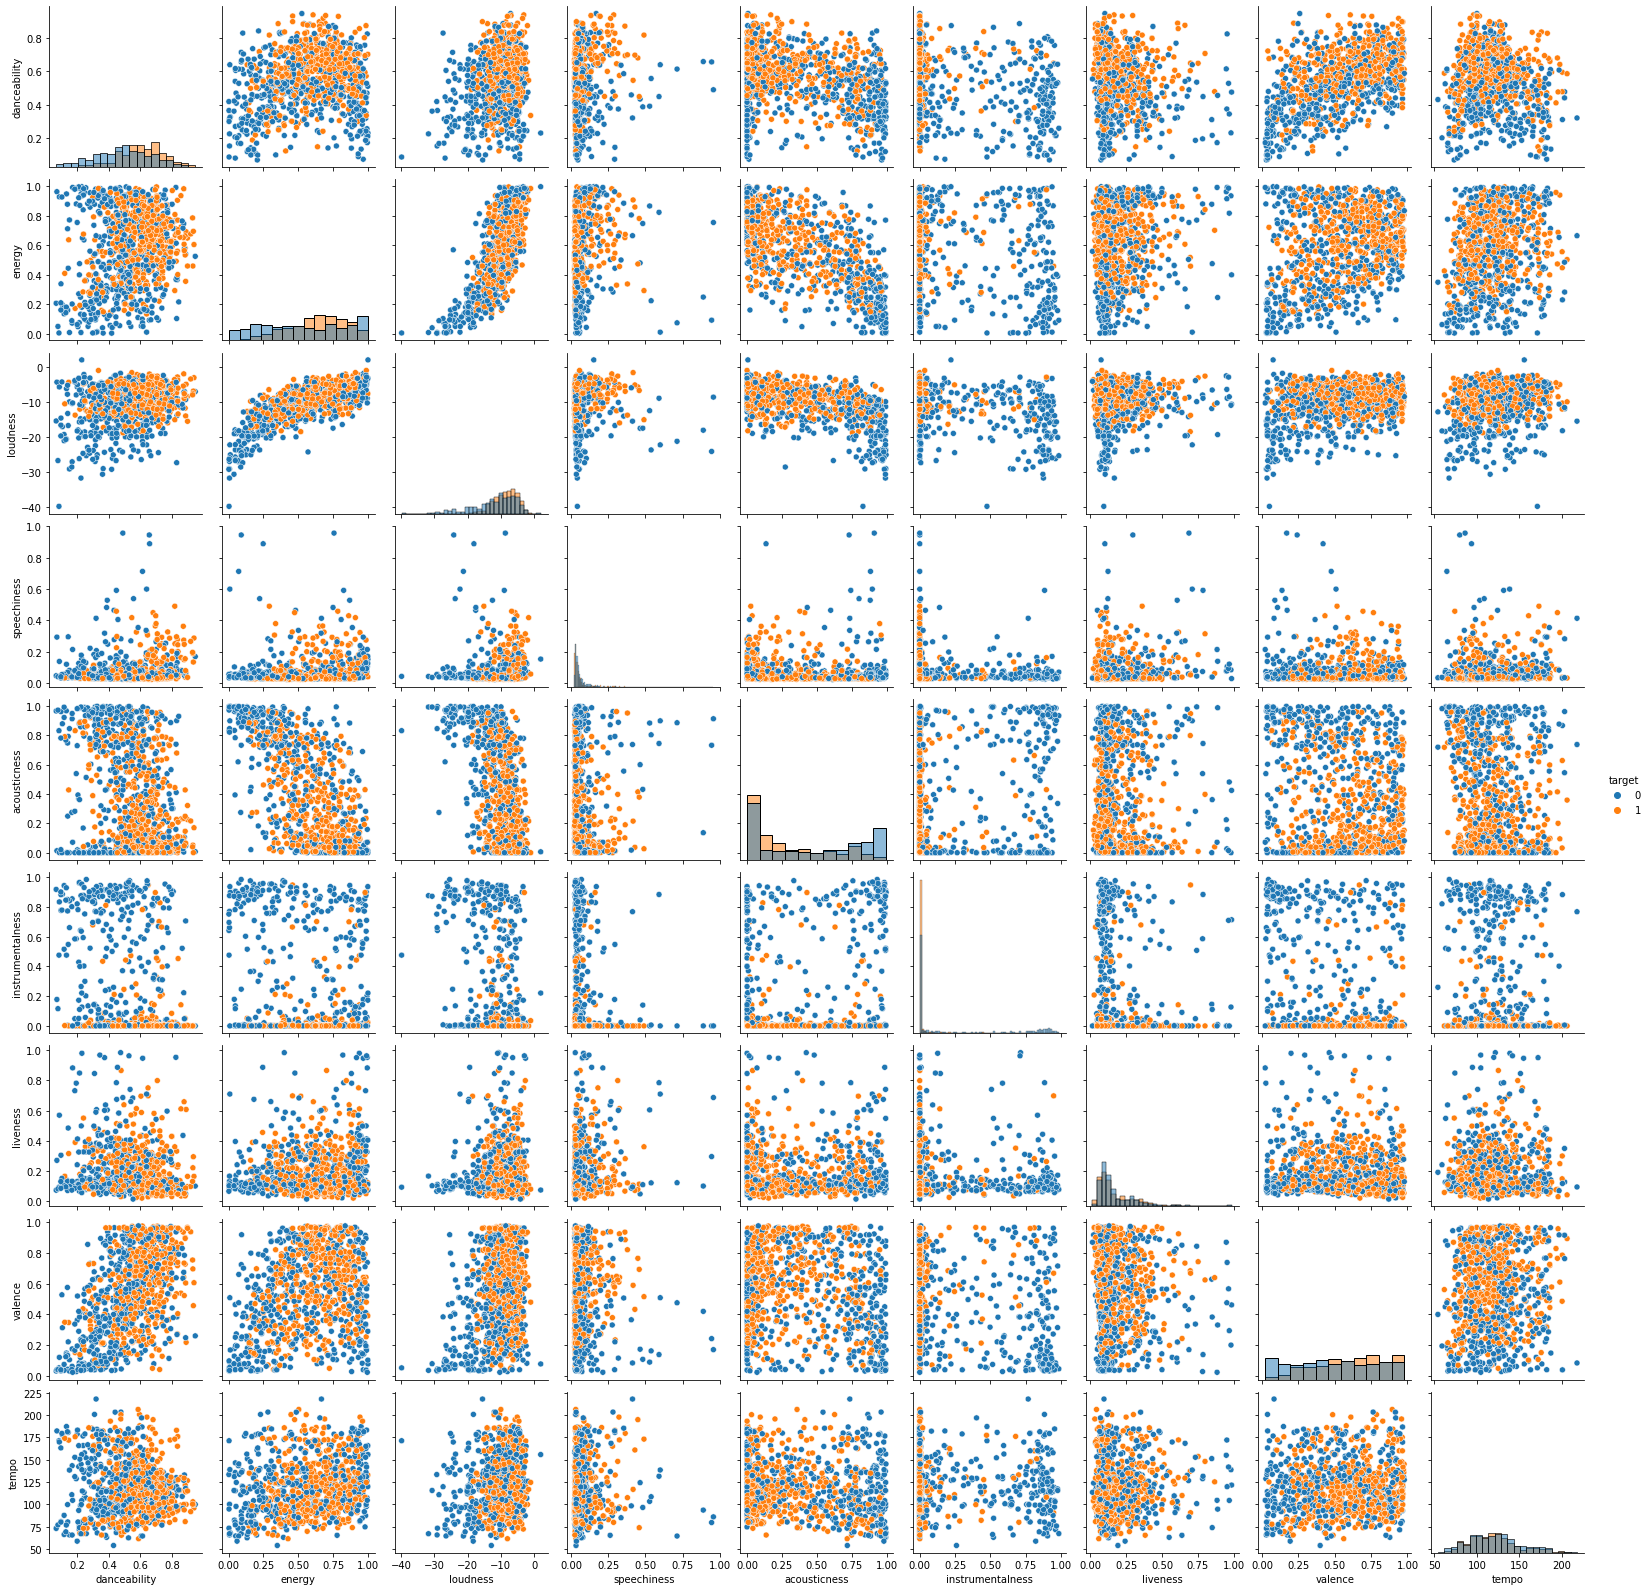

In [16]:
random_subset = np.random.choice(np.arange(df.shape[0]), size=1000, replace=False)
plt.rcParams['figure.figsize'] = (20, 20)

df_subset = df[['danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'target']]

sns.pairplot(df_subset.iloc[random_subset], diag_kind='hist', hue='target')

Для проверки этих гипотез о зависимости признаков была построена матрица корреляции Спирмана.

<AxesSubplot:>

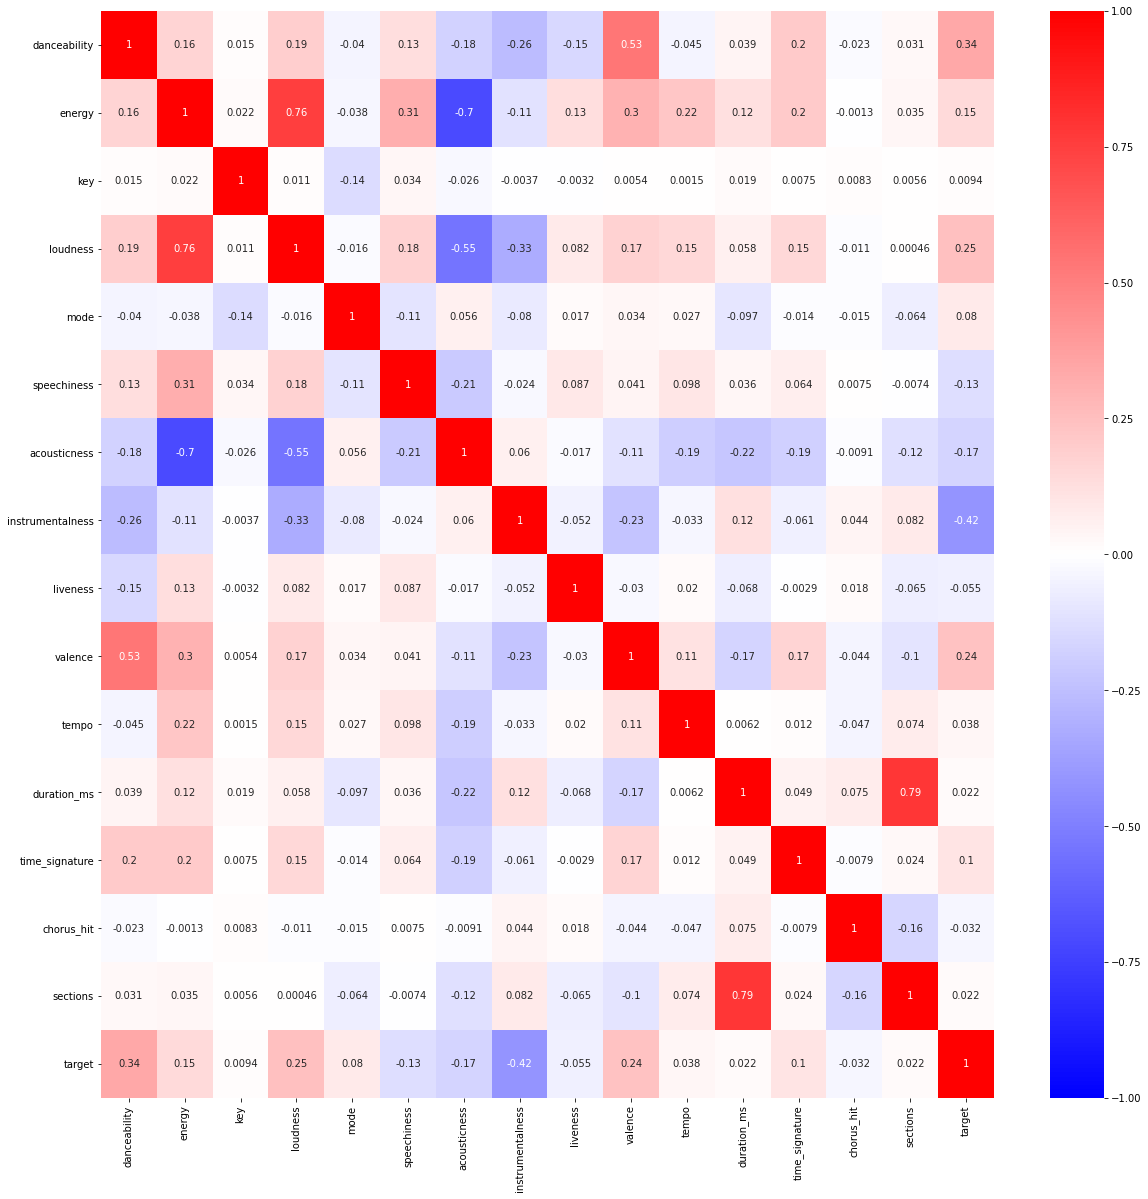

In [17]:
corr = df.corr(method='spearman')

sns.heatmap(corr, center=0, annot=True, cmap='bwr', vmin=-1, vmax=1,
        xticklabels=corr.columns,
        yticklabels=corr.columns)

Для удобства, можно отдельно вывести сочетания признаков, для которых корреляция является, как минимум умеренной, например те, корреляция которых больше 0.4 по модулю

In [18]:
corr.where(np.triu((corr > 0.4) | (corr < -0.4), k=1)).stack().sort_values(ascending=False)

duration_ms       sections        0.785411
energy            loudness        0.755831
danceability      valence         0.534031
instrumentalness  target         -0.420482
loudness          acousticness   -0.545557
energy            acousticness   -0.704296
dtype: float64

Целевой признак коррелирует с малым количеством признаком и сильной корреляции (например более 0.7) не наблюдается. Отдельно стоит отметить признак instrumentalness, с которым есть умеренная корреляция у целевого признака target.

# 3. Борьба с выбросами

При визуализации было замечено, что некоторые признаки имеют достаточно редкие значения (например, time_signature имеет всего 3 значения, равных нулю), которые могут быть выбросами. Поэтому, для признаков time_signature, tempo, duration_ms, chorus_hit, sections стоит построить график "ящик с усами" (boxplot) чтобы увидеть аномальные значения.

<AxesSubplot:>

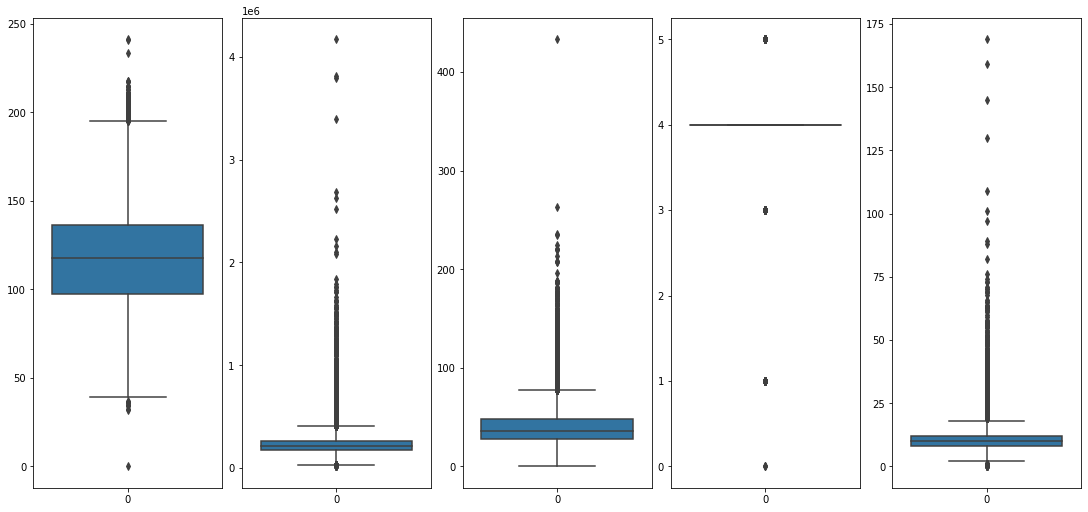

In [19]:
fig, ax = plt.subplots(1,5, figsize=(15,7), constrained_layout=True)

sns.boxplot(data=df['tempo'], ax=ax[0])
sns.boxplot(data=df['duration_ms'], ax=ax[1])
sns.boxplot(data=df['chorus_hit'], ax=ax[2])
sns.boxplot(data=df['time_signature'], ax=ax[3])
sns.boxplot(data=df['sections'], ax=ax[4])

На графиках видно, что эти признаки содержат много нетипичных значений и поэтому их можно удалить, например, используя информацию о квантилях. Во-первых, избавимся от объектов, у которых значение признака 'time_signature' равно нулю (т.к. такие композиции явно не будут являться "хитами".

In [20]:
df = df.drop(df[(df['time_signature'] == 0)].index)
df.shape

(41103, 17)

In [21]:
ej_columns = ['tempo', 'duration_ms', 'time_signature', 'chorus_hit', 'sections']

flag = np.zeros(df.shape[0])

for col in ej_columns:
    flag = flag | (df[col] < df[col].quantile(0.005)) | (df[col] > df[col].quantile(0.995))

df_clean = df.drop(df[flag].index)

print(f"Previous data shape is: {df.shape}, new data shape is: {df_clean.shape}")

Previous data shape is: (41103, 17), new data shape is: (39991, 17)


Как мы видим, процент выбросов около приблизительно равен 3.

# 4. Обработка пропущенных значений

In [22]:
df_clean.isna().sum()

artist              0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
chorus_hit          0
sections            0
target              0
dtype: int64

В данном датасете отсутствуют пропущенные значения.

# 5. Обработка категориальных признаков

Всего в датасете (после удаления признаков uri и track) есть 2 категориальных признака - это mode и artist.

In [23]:
df['mode']

0        1
1        0
2        1
3        1
4        1
        ..
41101    0
41102    0
41103    0
41104    1
41105    1
Name: mode, Length: 41103, dtype: int64

mode уже бинарный признак и его можно оставить как есть.

In [24]:
len(df['artist'].unique())

11903

Так как признак artist содержит 11903 уникальных значения, то просто бинаризовать его не выйдет. Поэтому кодируем их в базисе размерности 5 с помощью 6 новых признаков.

In [25]:
encoder = ce.BaseNEncoder(base=5, drop_invariant=True)
artist_ = encoder.fit_transform(df_clean['artist'])
artist_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39991 entries, 0 to 41105
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   artist_0  39991 non-null  int64
 1   artist_1  39991 non-null  int64
 2   artist_2  39991 non-null  int64
 3   artist_3  39991 non-null  int64
 4   artist_4  39991 non-null  int64
 5   artist_5  39991 non-null  int64
dtypes: int64(6)
memory usage: 2.1 MB


In [26]:
df_clean = pd.concat((df_clean, artist_), axis=1)
df_clean = df_clean.drop(['artist'], axis=1)
df_clean.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,time_signature,chorus_hit,sections,target,artist_0,artist_1,artist_2,artist_3,artist_4,artist_5
0,0.578,0.471,4,-7.270,1,0.0289,0.368000,0.00000,0.159,0.532,...,4,30.88059,13,1,0,0,0,0,0,1
1,0.704,0.854,10,-5.477,0,0.1830,0.018500,0.00000,0.148,0.688,...,4,41.51106,10,1,0,0,0,0,0,2
2,0.162,0.836,9,-3.009,1,0.0473,0.000111,0.00457,0.174,0.300,...,4,65.32887,13,0,0,0,0,0,0,3
3,0.188,0.994,4,-3.745,1,0.1660,0.000007,0.07840,0.192,0.333,...,4,58.59528,9,0,0,0,0,0,0,4
4,0.630,0.764,2,-4.353,1,0.0275,0.363000,0.00000,0.125,0.631,...,4,22.62384,10,1,0,0,0,0,1,0


In [27]:
df_clean.shape

(39991, 22)

В результате обработки вместо 1 старого признака было получено 6 новых

# 6. Нормализация количественных признаков

Наши признаки находятся в разных числовых диапазонах, для точности применяемых алгоритмов машинного обучения, и их более качественной работы, перед применением алгоритмов количественные признаки должны быть нормализованы. В качестве алгоритма нормализации будем использовать стандартизацию.

In [28]:
df_clean.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'chorus_hit', 'sections', 'target',
       'artist_0', 'artist_1', 'artist_2', 'artist_3', 'artist_4', 'artist_5'],
      dtype='object')

In [29]:
features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'chorus_hit', 'sections', 'artist_0', 
            'artist_1', 'artist_2', 'artist_3', 'artist_4', 'artist_5']

df_copy = df_clean.copy()
df_copy[features] = df_copy[features].apply(lambda x: (x - np.mean(x)) / (np.std(x)))
df_copy.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,time_signature,chorus_hit,sections,target,artist_0,artist_1,artist_2,artist_3,artist_4,artist_5
count,3.999100e+04,3.999100e+04,3.999100e+04,3.999100e+04,3.999100e+04,3.999100e+04,3.999100e+04,3.999100e+04,3.999100e+04,3.999100e+04,...,3.999100e+04,3.999100e+04,3.999100e+04,39991.000000,3.999100e+04,3.999100e+04,3.999100e+04,3.999100e+04,3.999100e+04,3.999100e+04
mean,1.300032e-14,-4.856878e-15,-9.654618e-16,3.317176e-15,-9.043136e-16,-1.222651e-14,-1.243349e-15,-6.519836e-16,5.985604e-15,3.754769e-14,...,1.195187e-14,1.283778e-14,-5.049584e-15,0.508289,-8.835730e-14,2.369305e-14,6.664889e-15,3.965826e-15,-5.606980e-16,-3.041002e-16
std,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,...,1.000013e+00,1.000013e+00,1.000013e+00,0.499938,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00
min,-2.750401e+00,-2.327115e+00,-1.475213e+00,-7.478609e+00,-1.506622e+00,-6.059056e-01,-1.067241e+00,-4.991006e-01,-1.092207e+00,-2.058680e+00,...,-6.949559e+00,-1.837610e+00,-1.982613e+00,0.000000,-1.315832e+00,-1.292527e+00,-1.398095e+00,-1.448254e+00,-1.411209e+00,-1.408779e+00
25%,-6.666591e-01,-7.234782e-01,-9.097428e-01,-4.938424e-01,-1.506622e+00,-4.653245e-01,-9.532277e-01,-4.991006e-01,-6.217742e-01,-7.973434e-01,...,2.480743e-01,-7.064354e-01,-6.330112e-01,0.000000,-1.315832e+00,-6.407135e-01,-6.831363e-01,-7.311918e-01,-7.035252e-01,-6.979102e-01
50%,7.104919e-02,8.682434e-02,-6.153704e-02,1.804566e-01,6.637365e-01,-3.477695e-01,-3.190260e-01,-4.987460e-01,-4.002229e-01,6.111834e-02,...,2.480743e-01,-2.298179e-01,-9.317048e-02,1.000000,-2.987371e-01,1.109962e-02,3.182284e-02,-1.412931e-02,4.158578e-03,1.295850e-02
75%,7.236373e-01,8.212858e-01,7.866687e-01,7.236419e-01,6.637365e-01,-3.025005e-02,9.101852e-01,-3.319876e-01,3.470037e-01,8.405112e-01,...,2.480743e-01,4.537102e-01,4.466702e-01,1.000000,7.183576e-01,1.314726e+00,7.467820e-01,7.029332e-01,7.118424e-01,7.238272e-01
max,2.522511e+00,1.663521e+00,1.634874e+00,2.650593e+00,6.637365e-01,1.071330e+01,1.889991e+00,2.846505e+00,4.641376e+00,1.691443e+00,...,2.647285e+00,4.828265e+00,6.114998e+00,1.000000,1.735452e+00,1.314726e+00,1.461741e+00,1.419996e+00,1.419526e+00,1.434696e+00


# 7. Разделение выборки на обучающую и тестовую

Для того, чтобы избежать переобучения модели необходимо разделить исходную выборку на 2: обучающую и тестовую. Обучающая будет использоваться при обучении модели, в то время как на тестовой будут проводиться замеры метрик для оценки качества модели. Делить будет в пропорции 1 к 3. Для деления используем готовую функцию train_test_split.

In [32]:
data_X = np.array(df_copy.drop(['target'], axis=1))
data_y = np.array(df_copy['target'])

train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size = 0.3, random_state = 17)

print(f"Train data_X shape is: {train_X.shape}, test data_X shape is: {test_X.shape}")
print(f"Train data_y shape is: {train_y.shape}, test data_y shape is: {test_y.shape}")

Train data_X shape is: (27993, 21), test data_X shape is: (11998, 21)
Train data_y shape is: (27993,), test data_y shape is: (11998,)


# 8. Применение методов машинного обучения (KNN)

In [33]:
knn = KNeighborsClassifier()
k_range = list(range(1, 64))
param_grid = dict(n_neighbors=k_range)

grid = GridSearchCV(knn, param_grid, cv=10, scoring='f1', return_train_score=False, verbose=1)
  
grid_search = grid.fit(train_X, train_y)

Fitting 10 folds for each of 63 candidates, totalling 630 fits


In [34]:
grid.best_params_

{'n_neighbors': 17}

Благодаря функции GridSearchCV удалось выяснить, что оптимальное число соседей - это 17. 

In [35]:
neigh = KNeighborsClassifier(n_neighbors=17)
neigh.fit(train_X, train_y)

y_pred = neigh.predict(test_X)
print(f"f1-мера: {f1_score(test_y, y_pred):.3f}, ошибка: {np.mean(test_y != y_pred):.3f}")

f1-мера: 0.795, ошибка: 0.236


In [36]:
target_names = ['Flop', 'Hit']
print(classification_report(test_y, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        Flop       0.87      0.61      0.72      5963
         Hit       0.71      0.91      0.80      6035

    accuracy                           0.76     11998
   macro avg       0.79      0.76      0.76     11998
weighted avg       0.79      0.76      0.76     11998



# 9. Применение нейронной сети MLP - Multi Layer Perceptron

In [37]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes = (30,), random_state = 42)
model.fit(train_X, train_y)

C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(30,), random_state=42)

In [38]:
train_y_pred = model.predict(train_X)
test_y_pred = model.predict(test_X)
np.mean(train_y != train_y_pred), np.mean(test_y != test_y_pred)

(0.1844746901010967, 0.19678279713285549)

In [39]:
model = MLPClassifier(hidden_layer_sizes = (1000, 500), random_state = 42)
model.fit(train_X, train_y)

MLPClassifier(hidden_layer_sizes=(1000, 500), random_state=42)

In [40]:
train_y_pred = model.predict(train_X)
test_y_pred = model.predict(test_X)
np.mean(train_y != train_y_pred), np.mean(test_y != test_y_pred)

(3.5723216518415315e-05, 0.1736122687114519)

In [49]:
model = MLPClassifier(hidden_layer_sizes = (512), random_state = 42)
model.fit(train_X, train_y)

C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=512, random_state=42)

In [50]:
train_y_pred = model.predict(train_X)
test_y_pred = model.predict(test_X)
np.mean(train_y != train_y_pred), np.mean(test_y != test_y_pred)

(0.056799914264280355, 0.1924487414569095)

# 9.1 Подбор гиперпараметров

In [96]:
alpha_arr = np.logspace(-4, 5, 10)
test_err = []
train_err = []
for alpha in alpha_arr:
    mlp_model = MLPClassifier(hidden_layer_sizes = (512), random_state=42, alpha=alpha)
    mlp_model.fit(train_X, train_y)

    train_y_pred = model.predict(train_X)
    test_y_pred = model.predict(test_X)
    train_err.append(np.mean(train_y != train_y_pred))
    test_err.append(np.mean(test_y != test_y_pred))

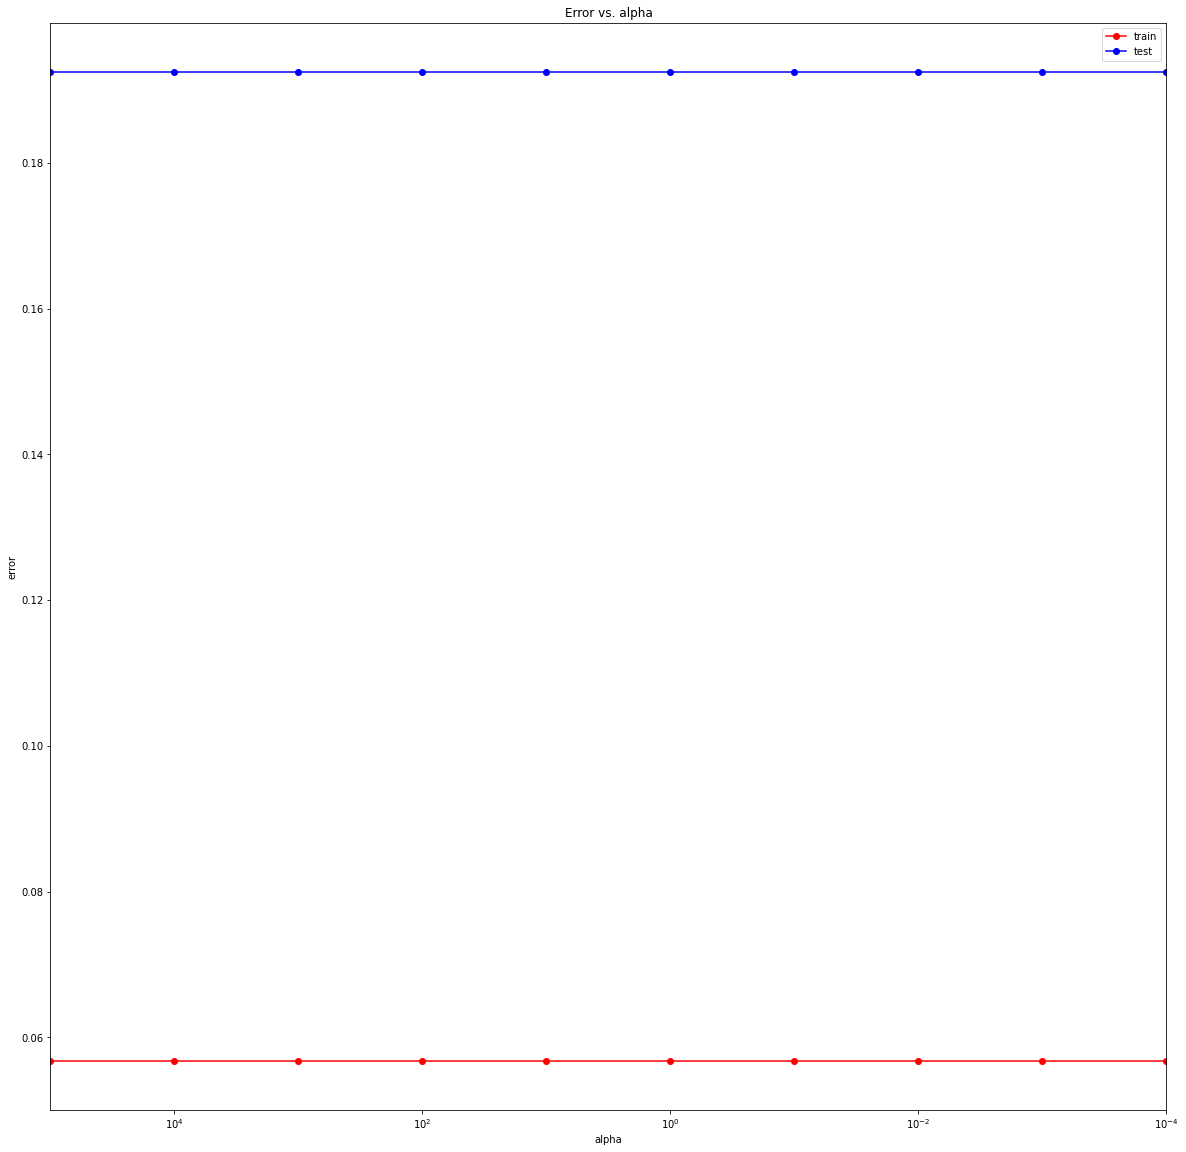

In [97]:
plt.semilogx(alpha_arr, train_err, 'r-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'b-o', label = 'test')
plt.xlim([np.max(alpha_arr), np.min(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()
pass

In [98]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.056799914264280355 0.1924487414569095


In [99]:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05]


# 10 Использование pytorch

In [100]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchsummary import summary
from torchvision import datasets
import warnings
warnings.filterwarnings("ignore")

In [277]:
class SimpleNet(nn.Module):

    def __init__(self, num_classes=2):
        super(SimpleNet, self).__init__()
        
        self.linear1 = nn.Linear(21, 512)
        self.linear2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = x.view(-1, 21)
        x = self.linear1(x)
        nn.LeakyReLU()
        
        x = self.linear2(x)
        
        return x
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
simplenet = SimpleNet().to(device)
optimizer = optim.Adam(simplenet.parameters(), lr=0.001)

summary(simplenet, (1, 21))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]          11,264
            Linear-2                    [-1, 2]           1,026
Total params: 12,290
Trainable params: 12,290
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


In [278]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
class ShelterOutcomeDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X.astype(np.float32)
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [279]:
train_dataset = ShelterOutcomeDataset(train_X, train_y)
test_dataset = ShelterOutcomeDataset(test_X, test_y)

In [280]:
batch_size = 1000
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [281]:
def train(model, optimizer, loss_fn, train_loader, test_loader, epochs=20, device="cpu"):
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        
        training_loss = 0.0
        test_loss = 0.0
        model.train(mode=True)
        
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            #print(inputs.shape)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        train_losses.append(training_loss)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        
        for batch in test_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output  = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            test_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        
        print('Epoch: {}, Training Loss: {:.4f}, Test Loss: {:.4f}, accuracy = {:.4f}'.format(epoch, training_loss,
        test_loss, num_correct / num_examples))
    
    plt.plot(train_losses, 'r-o', label = 'train')
    plt.plot(test_losses, 'b-o', label = 'test')
    plt.title('Train loss vs test loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()

Epoch: 0, Training Loss: 0.5655, Test Loss: 0.5282, accuracy = 0.7318
Epoch: 1, Training Loss: 0.5359, Test Loss: 0.5266, accuracy = 0.7290
Epoch: 2, Training Loss: 0.5345, Test Loss: 0.5266, accuracy = 0.7298
Epoch: 3, Training Loss: 0.5352, Test Loss: 0.5270, accuracy = 0.7300
Epoch: 4, Training Loss: 0.5339, Test Loss: 0.5262, accuracy = 0.7312
Epoch: 5, Training Loss: 0.5344, Test Loss: 0.5266, accuracy = 0.7308
Epoch: 6, Training Loss: 0.5348, Test Loss: 0.5281, accuracy = 0.7296
Epoch: 7, Training Loss: 0.5346, Test Loss: 0.5265, accuracy = 0.7283
Epoch: 8, Training Loss: 0.5343, Test Loss: 0.5281, accuracy = 0.7307
Epoch: 9, Training Loss: 0.5344, Test Loss: 0.5286, accuracy = 0.7279
Epoch: 10, Training Loss: 0.5345, Test Loss: 0.5261, accuracy = 0.7315
Epoch: 11, Training Loss: 0.5345, Test Loss: 0.5262, accuracy = 0.7311
Epoch: 12, Training Loss: 0.5348, Test Loss: 0.5266, accuracy = 0.7315
Epoch: 13, Training Loss: 0.5345, Test Loss: 0.5264, accuracy = 0.7311
Epoch: 14, Train

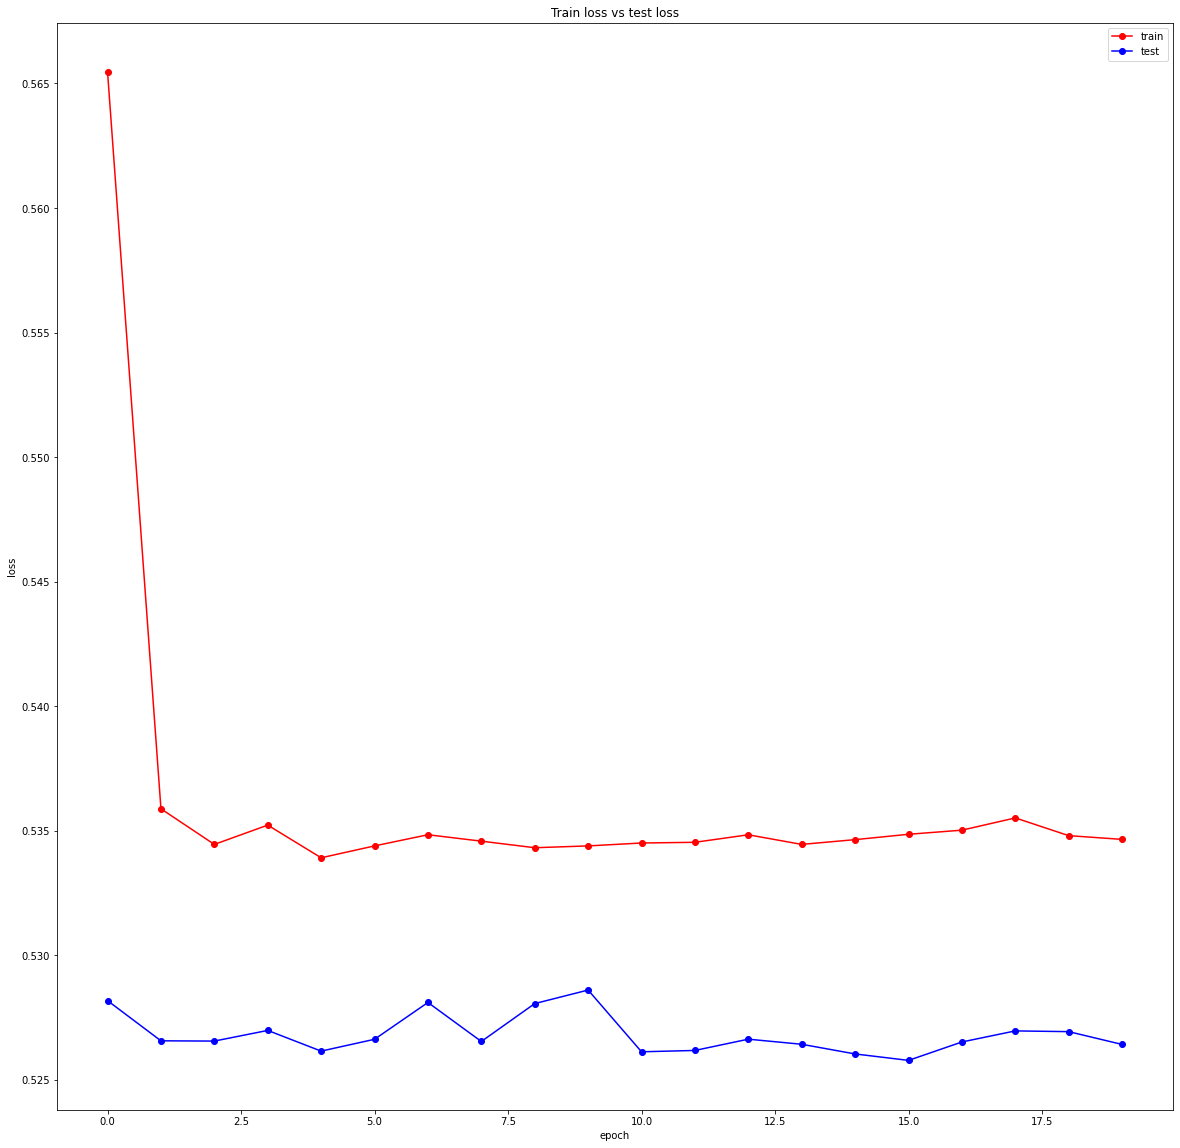

In [282]:
train(simplenet, optimizer, torch.nn.CrossEntropyLoss(), train_loader, test_loader, epochs=20, device=device)

# 11. Выводы

1) Благодаря применению метода gridsearch удалось найти оптимальное число соседей для метода knn, а именно - 17. Значение  f1-меры с таким числом соседей достигло 0.795, а accuracy - 0.76.
2) Также был применён метод MLPClassifier, и был осуществлён поиск оптимальных параметров, однако, как показал график, в данном случае параметр alpha не повлиял на ошибки на тестовой и трейновой выборках. В случае с полносвязной сетью с 2 слоями (1000, 500) удалось достигнуть крайне низкой ошибки на трейновой выборке (3.5723216518415315e-05), и достаточно низкой на тестовой  (0.1736122687114519)
3) Также была реализована полносвязная сеть с помощью pytorch, ошибки на тестовой и трейновой выборках стабилизировались достаточно быстро и не было смысла обучать сеть большое количество эпох, обучение можно было останавливать уже на 5. Accuracy на тестовой выборке держалось в районе значения 0.73. 